In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

plt.style.use(style="seaborn-v0_8-talk")
sns.set_theme(style="darkgrid")

import torch
import torch.nn as nn
from torch.utils.data import DataLoader

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

from battery_predictor import BatteryPredictor
from battery_dataset import BatteryDataset

cpu


In [3]:
from torch.utils.data import DataLoader

features = np.load("features_eis.npy")
capacity = np.load("capacity.npy")

X = torch.tensor(features).to(device)
y_true = torch.tensor(capacity).to(device)
X = X.float()
y_true = y_true.float()

print(X.shape, y_true.shape)

torch.Size([152, 55]) torch.Size([152])


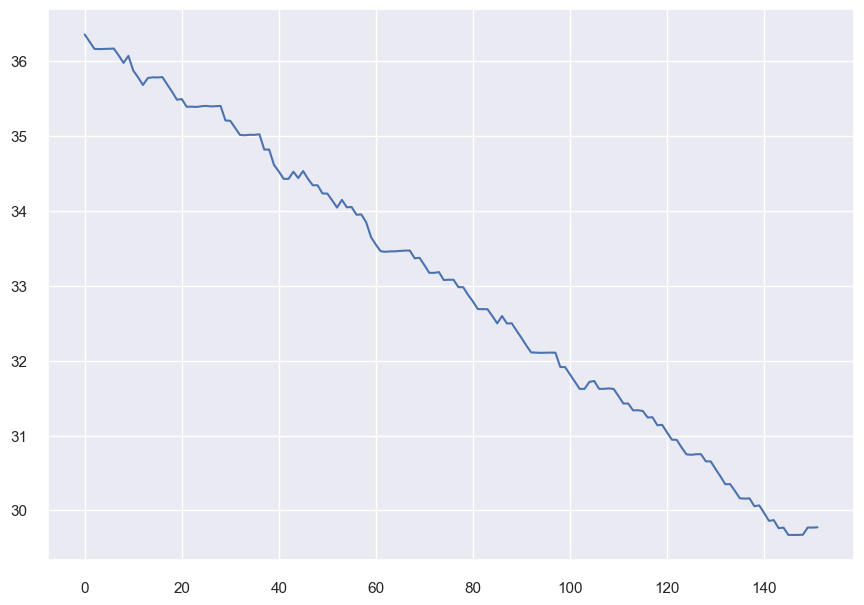

In [4]:
plt.plot(y_true)

In [5]:
min_y = torch.min(y_true, axis=0)[0].item()
max_y = torch.max(y_true, axis=0)[0].item()

print(min_y, max_y)

29.67250633239746 36.35528564453125


In [6]:
def normalize_0_1(array):
    min_value = torch.min(array, axis=0)[0]
    max_value = torch.max(array, axis=0)[0]
    normalized_array = (array - min_value) / (max_value - min_value)
    return normalized_array

X_norm = normalize_0_1(X)
y_norm = normalize_0_1(y_true)

In [7]:
BATCH_SIZE = 16
dataset = BatteryDataset(X_norm, y_norm)
dataloader = DataLoader(dataset, batch_size=BATCH_SIZE, shuffle=False)

# 将训练集分为训练集和验证集
train_size = int(0.8 * len(dataset))
val_size = len(dataset) - train_size
train_dataset, val_dataset = torch.utils.data.random_split(dataset, [train_size, val_size])

# train_dataloader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
train_dataloader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=False)
val_dataloader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False)

In [8]:
# 设置随机种子
def set_seed(seed):
    torch.manual_seed(seed)
    # torch.cuda.manual_seed_all(seed)
    np.random.seed(seed)
    # random.seed(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False


In [9]:
set_seed(42)
predictor = BatteryPredictor(input_len=X.shape[1]).to(device)
loss_list = []

模型训练


In [10]:
from tqdm import tqdm

predictor.train()

criterion = nn.MSELoss()
optimizer = torch.optim.Adam(predictor.parameters(), lr=1e-4)

for epoch in range(300):
    tqdm_dataloader = tqdm(train_dataloader, desc=f'Epoch: {epoch+1}')
    for batch_X, batch_y in tqdm_dataloader:
        batch_X, batch_y = batch_X.to(device), batch_y.to(device)
        output = predictor(batch_X)
        
        loss = criterion(output, batch_y.unsqueeze(1))
        loss_list.append(loss.item())
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        tqdm_dataloader.set_postfix(loss=loss.item())


Epoch: 300: 100%|██████████| 8/8 [00:00<00:00, 150.30it/s, loss=9.46e-5]


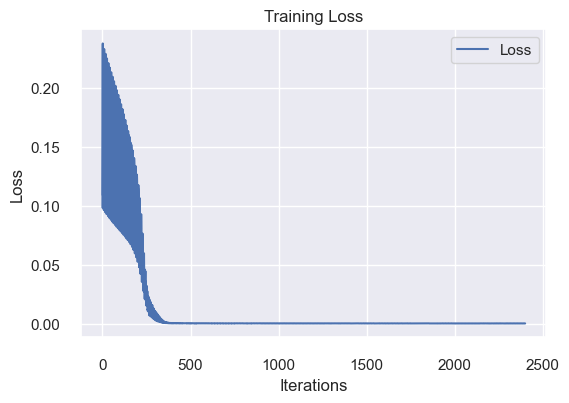

In [11]:
plt.figure(figsize=(6, 4))
plt.plot(loss_list, label="Loss")
plt.title("Training Loss")
plt.xlabel("Iterations")
plt.ylabel("Loss")
plt.legend()

plt.show()

模型评估


In [12]:
# calculate the training error
y_true, y_pred = np.array([]), np.array([])
with torch.no_grad():
    for batch_X, batch_y in train_dataloader:
        batch_X, batch_y = batch_X.to(device), batch_y.to(device)
        output = predictor(batch_X)
        y_true = np.append(y_true, batch_y.cpu().numpy())
        y_pred = np.append(y_pred, output.cpu().numpy())

print("训练集:")
print(f"shape: y_true {y_true.shape}, y_pred {y_pred.shape}")

y_true = y_true * (max_y - min_y) + min_y
y_pred = y_pred * (max_y - min_y) + min_y

error = np.abs(y_pred - y_true)
print(f"训练集 Mean error: {error.mean():.5f} mAh")

relative_error = error / y_true
print(f"训练集 Mean relative error: {relative_error.mean():.5f}")

print(f"error shape: {error.shape}, relative_error shape: {relative_error.shape}")
print('-'*50)

# calculate the validation error
y_true, y_pred = np.array([]), np.array([])
with torch.no_grad():
    for batch_X, batch_y in val_dataloader:
        batch_X, batch_y = batch_X.to(device), batch_y.to(device)
        output = predictor(batch_X)
        y_true = np.append(y_true, batch_y.cpu().numpy())
        y_pred = np.append(y_pred, output.cpu().numpy())

print("验证集:")
print(f"shape: y_true {y_true.shape}, y_pred {y_pred.shape}")

y_true = y_true * (max_y - min_y) + min_y
y_pred = y_pred * (max_y - min_y) + min_y

error = np.abs(y_pred - y_true)
print(f"验证集 Mean error: {error.mean():.5f} mAh")

relative_error = error / y_true
print(f"验证集 Mean relative error: {relative_error.mean():.5f}")

print(f"error shape: {error.shape}, relative_error shape: {relative_error.shape}")

训练集:
shape: y_true (121,), y_pred (121,)
训练集 Mean error: 0.05099 mAh
训练集 Mean relative error: 0.00154
error shape: (121,), relative_error shape: (121,)
--------------------------------------------------
验证集:
shape: y_true (31,), y_pred (31,)
验证集 Mean error: 0.06186 mAh
验证集 Mean relative error: 0.00185
error shape: (31,), relative_error shape: (31,)


In [13]:
y_true, y_pred = [], []
with torch.no_grad():
    for batch_X, batch_y in dataloader:
        batch_X, batch_y = batch_X.to(device), batch_y.to(device)
        output = predictor(batch_X)
        y_true.extend(batch_y.cpu().numpy())
        y_pred.extend(output.cpu().numpy())
        
y_true = np.array(y_true) * (max_y - min_y) + min_y
y_pred = np.array(y_pred) * (max_y - min_y) + min_y

In [14]:
def plot_predictions(y_true, y_pred):
    plt.figure(figsize=(8, 5))
    plt.plot(list(range(1, len(y_true)+1)), y_true, label="True")
    plt.scatter(list(range(1, len(y_pred)+1)), y_pred, label="Predicted", color="orange", s=3)
    plt.title("Predictions of Capacity", fontsize=18)
    plt.xlabel("Cycle", fontsize=16)
    plt.ylabel("Capacity (mAh)", fontsize=16)
    plt.legend()
    plt.show()

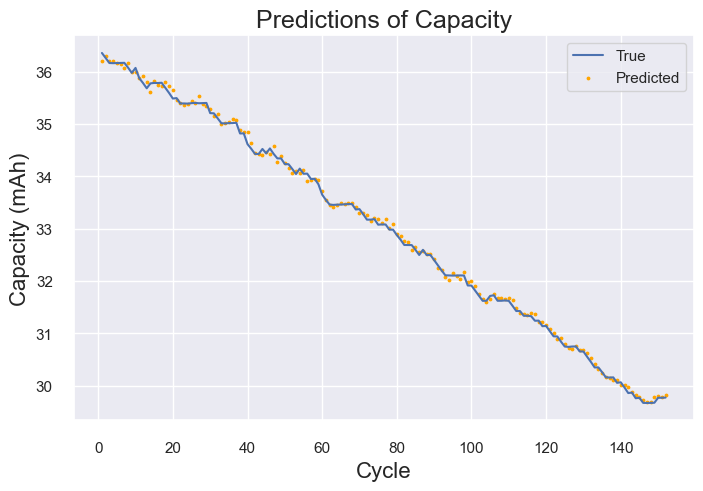

In [15]:
plot_predictions(y_true, y_pred)


In [16]:
# Metrics
from sklearn.metrics import mean_squared_error, r2_score

def calculate_metrics(predictor, dataloader, device):
    y, y_pred = [], []
    with torch.no_grad():
        for batch_X, batch_y in dataloader:
            batch_X, batch_y = batch_X.to(device), batch_y.to(device)
            output = predictor(batch_X)
            y.extend(batch_y.cpu().numpy())
            y_pred.extend(output.cpu().numpy())
    
    mse = mean_squared_error(y, y_pred)
    r2 = r2_score(y, y_pred)
    return mse, r2

mse_train, r2_train = calculate_metrics(predictor, train_dataloader, device)

print(f"Train MSE: {mse_train:.4f}")
print(f"Train R2: {r2_train:.4f}")

Train MSE: 0.0001
Train R2: 0.9991


保存模型


In [50]:
path = "preditor_cell.pth"
torch.save(predictor.state_dict(), path)
print(f"模型已保存到 {path}")

模型已保存到 preditor_cell.pth


保存预测容量结果

In [66]:
y_pred = []
with torch.no_grad():
    for batch_X, batch_y in dataloader:
        batch_X, batch_y = batch_X.to(device), batch_y.to(device)
        output = predictor(batch_X)
        y_pred.extend(output.cpu().numpy())
        
y_pred = np.array(y_pred) * (max_y - min_y) + min_y
y_pred = y_pred.squeeze()
        
np.save("capacity_pred.npy", y_pred)